In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wishart, multivariate_normal

/var/folders/7y/3gfjsqv1527blyqnj1bgm7br0000gn/T/ipykernel_53390/1098583919.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logu = float(joint - np.random.exponential(1, size=1))
/var/folders/7y/3gfjsqv1527blyqnj1bgm7br0000gn/T/ipykernel_53390/1098583919.py:50: RuntimeWarning: overflow encountered in exp
  alphaprime = min(1., np.exp(joint - joint0))


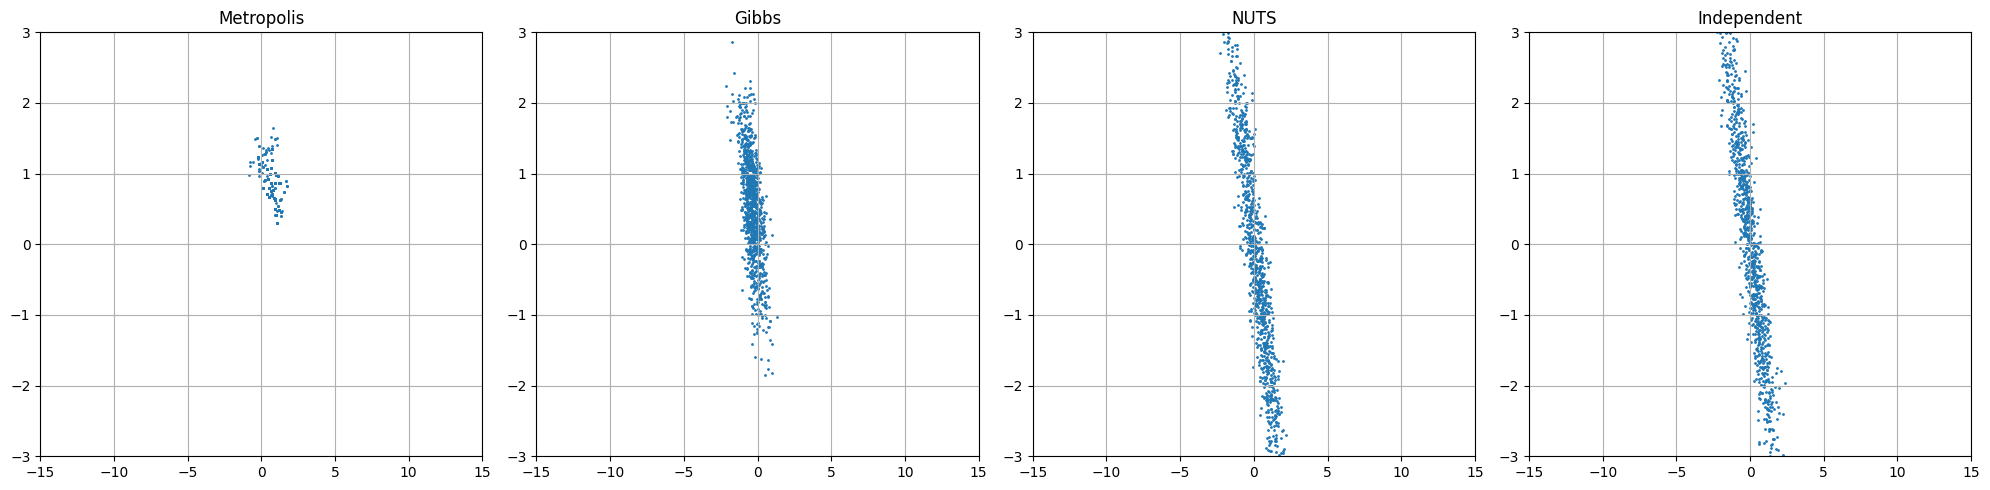

In [2]:
'''
All code for functions implementing the NUTS algorithm is adapted from publicly available code at https://mc-stan.org/
'''

def leapfrog(theta, r, grad, epsilon, f):
    """
    Performs a single leapfrog integration step in Hamiltonian Monte Carlo.

    The leapfrog integrator simulates Hamiltonian dynamics by alternating updates
    for position (`theta`) and momentum (`r`). It preserves volume and reversibility,
    essential for maintaining the correctness of the Markov chain.

    Parameters:
        theta (numpy.ndarray): Current position vector in parameter space.
        r (numpy.ndarray): Current momentum vector.
        grad (numpy.ndarray): Gradient of the log-posterior at `theta`.
        epsilon (float): Step size for the leapfrog integration.
        f (function): Function that returns the log-posterior and its gradient given `theta`.

    Returns:
        thetaprime (numpy.ndarray): Updated position vector after the leapfrog step.
        rprime (numpy.ndarray): Updated momentum vector after the leapfrog step.
        gradprime (numpy.ndarray): Gradient of the log-posterior at `thetaprime`.
        logpprime (float): Log-posterior value at `thetaprime`.
    """
    rprime = r + 0.5 * epsilon * grad
    thetaprime = theta + epsilon * rprime
    logpprime, gradprime = f(thetaprime)
    rprime = rprime + 0.5 * epsilon * gradprime
    return thetaprime, rprime, gradprime, logpprime


def find_reasonable_epsilon(theta0, grad0, logp0, f):
    """
    Determines a reasonable initial step size (`epsilon`) for leapfrog integration.

    The function adjusts `epsilon` iteratively until the acceptance probability of
    the proposal is approximately 0.5, ensuring a balance between exploration and efficiency.

    Parameters:
        theta0 (numpy.ndarray): Initial position in parameter space.
        grad0 (numpy.ndarray): Gradient of the log-posterior at `theta0`.
        logp0 (float): Log-posterior value at `theta0`.
        f (function): Function that computes the log-posterior and its gradient.

    Returns:
        epsilon (float): A reasonable step size for leapfrog integration.
    """
    epsilon = 1.
    r0 = np.random.normal(0., 1., len(theta0))

    _, rprime, gradprime, logpprime = leapfrog(theta0, r0, grad0, epsilon, f)
    k = 1.
    while np.isinf(logpprime) or np.isinf(gradprime).any():
        k *= 0.5
        _, rprime, _, logpprime = leapfrog(theta0, r0, grad0, epsilon * k, f)

    epsilon = 0.5 * k * epsilon

    logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))
    a = 1. if logacceptprob > np.log(0.5) else -1.
    while a * logacceptprob > -a * np.log(2):
        epsilon = epsilon * (2. ** a)
        _, rprime, _, logpprime = leapfrog(theta0, r0, grad0, epsilon, f)
        logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))

    return epsilon


def stop_criterion(thetaminus, thetaplus, rminus, rplus):
    """
    Evaluates the No-U-Turn condition to determine whether to stop tree expansion.

    The function computes the dot product between the trajectory direction and
    the momentum, checking if further simulation would retrace previous steps.

    Parameters:
        thetaminus (numpy.ndarray): Position vector at the backward end of the trajectory.
        thetaplus (numpy.ndarray): Position vector at the forward end of the trajectory.
        rminus (numpy.ndarray): Momentum vector at the backward end of the trajectory.
        rplus (numpy.ndarray): Momentum vector at the forward end of the trajectory.

    Returns:
        bool: `True` if the No-U-Turn condition is satisfied; otherwise, `False`.
    """
    dtheta = thetaplus - thetaminus
    return (np.dot(dtheta, rminus.T) >= 0) & (np.dot(dtheta, rplus.T) >= 0)


def build_tree(theta, r, grad, logu, v, j, epsilon, f, joint0):
    """
    Recursively builds a binary tree for exploring the trajectory in NUTS.

    At each depth, the tree expands forward or backward in fictitious time,
    doubling the trajectory size until a stopping criterion is met.

    Parameters:
        theta (numpy.ndarray): Current position in parameter space.
        r (numpy.ndarray): Current momentum vector.
        grad (numpy.ndarray): Gradient of the log-posterior at `theta`.
        logu (float): Log-uniform slice variable defining the trajectory region.
        v (int): Direction of tree expansion (`+1` for forward, `-1` for backward).
        j (int): Depth of the tree.
        epsilon (float): Step size for leapfrog integration.
        f (function): Function that computes the log-posterior and its gradient.
        joint0 (float): Initial joint density at the starting point.

    Returns:
        thetaminus (numpy.ndarray): Position vector at the backward end of the trajectory.
        thetaplus (numpy.ndarray): Position vector at the forward end of the trajectory.
        rminus (numpy.ndarray): Momentum vector at the backward end of the trajectory.
        rplus (numpy.ndarray): Momentum vector at the forward end of the trajectory.
        thetaprime (numpy.ndarray): Proposed sample position.
        nprime (int): Indicator for whether the proposed point satisfies the slice condition.
        sprime (int): Indicator for whether the subtree satisfies the stopping criterion.
    """
    if (j == 0):
        thetaprime, rprime, gradprime, logpprime = leapfrog(theta, r, grad, v * epsilon, f)
        joint = logpprime - 0.5 * np.dot(rprime, rprime.T)

        nprime = int(logu < joint)
        sprime = int((logu - 1000.) < joint)

        thetaminus = thetaprime[:]
        thetaplus = thetaprime[:]
        rminus = rprime[:]
        rplus = rprime[:]
        gradminus = gradprime[:]
        gradplus = gradprime[:]
        alphaprime = min(1., np.exp(joint - joint0))
        nalphaprime = 1
    else:
        thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime = build_tree(theta, r, grad, logu, v, j - 1, epsilon, f, joint0)

        if (sprime == 1):
            if (v == -1):
                thetaminus, rminus, gradminus, _, _, _, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaminus, rminus, gradminus, logu, v, j - 1, epsilon, f, joint0)
            else:
                _, _, _, thetaplus, rplus, gradplus, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaplus, rplus, gradplus, logu, v, j - 1, epsilon, f, joint0)

            if (np.random.uniform() < (float(nprime2) / max(float(int(nprime) + int(nprime2)), 1.))):
                thetaprime = thetaprime2[:]
                gradprime = gradprime2[:]
                logpprime = logpprime2
            nprime = int(nprime) + int(nprime2)
            sprime = int(sprime and sprime2 and stop_criterion(thetaminus, thetaplus, rminus, rplus))
            alphaprime = alphaprime + alphaprime2
            nalphaprime = nalphaprime + nalphaprime2

    return thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime


# NUTS algorithm
def efficient_nuts(f, M, Madapt, theta0, delta=0.6):
    """
    Implements the No-U-Turn Sampler (NUTS) algorithm for sampling from a target distribution.

    NUTS is an extension of Hamiltonian Monte Carlo (HMC) that eliminates the need to set the 
    number of leapfrog steps manually. It uses a recursive tree-building strategy to adaptively 
    set the path length based on the trajectory.

    Parameters:
        theta0 (numpy.ndarray): Initial position in parameter space.
        f (function): Function that computes the log-posterior and its gradient given `theta`.
        num_samples (int): Number of samples to draw from the target distribution.
        delta (float): Target acceptance probability for the dual averaging adaptation. Default is 0.65.

    Returns:
        samples (numpy.ndarray): Array of samples drawn from the target distribution.
        log_probs (numpy.ndarray): Log-posterior values corresponding to the samples.
    """
    if len(np.shape(theta0)) > 1:
        raise ValueError('Theta0 is expected to be a 1-D array')

    D = len(theta0)
    samples = np.empty((M + Madapt, D), dtype=float)
    lnprob = np.empty(M + Madapt, dtype=float)

    logp, grad = f(theta0)
    samples[0, :] = theta0
    lnprob[0] = logp

    epsilon = find_reasonable_epsilon(theta0, grad, logp, f)

    Sigma = np.eye(D)
    gamma = 0.05
    t0 = 10
    kappa = 0.75
    mu = np.log(10. * epsilon)

    epsilonbar = 1
    Hbar = 0

    for m in range(1, M + Madapt):
        r0 = np.random.normal(0, 1, D)

        joint = logp - 0.5 * r0.T @ np.linalg.inv(Sigma) @ r0

        logu = float(joint - np.random.exponential(1, size=1))

        samples[m, :] = samples[m - 1, :]
        lnprob[m] = lnprob[m - 1]

        thetaminus = samples[m - 1, :]
        thetaplus = samples[m - 1, :]
        rminus = r0[:]
        rplus = r0[:]
        gradminus = grad[:]
        gradplus = grad[:]

        j = 0 
        n = 1  
        s = 1  

        while (s == 1):
            v = int(2 * (np.random.uniform() < 0.5) - 1)

            if (v == -1):
                thetaminus, rminus, gradminus, _, _, _, thetaprime, gradprime, logpprime, nprime, sprime, alpha, nalpha = build_tree(thetaminus, rminus, gradminus, logu, v, j, epsilon, f, joint)
            else:
                _, _, _, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alpha, nalpha = build_tree(thetaplus, rplus, gradplus, logu, v, j, epsilon, f, joint)

            _tmp = min(1, float(nprime) / float(n))
            if (sprime == 1) and (np.random.uniform() < _tmp):
                samples[m, :] = thetaprime[:]
                lnprob[m] = logpprime
                logp = logpprime
                grad = gradprime[:]
            n += nprime
            s = sprime and stop_criterion(thetaminus, thetaplus, rminus, rplus)
            j += 1

        eta = 1. / float(m + t0)
        Hbar = (1. - eta) * Hbar + eta * (delta - alpha / float(nalpha))
        if (m <= Madapt):
            epsilon = np.exp(mu - np.sqrt(m) / gamma * Hbar)
            eta = m ** -kappa
            epsilonbar = np.exp((1. - eta) * np.log(epsilonbar) + eta * np.log(epsilon))
        else:
            epsilon = epsilonbar
    samples = samples[Madapt:, :]
    lnprob = lnprob[Madapt:]
    return samples, lnprob, epsilon

def log_prob(theta):
    """
    Computes the log-probability of the target distribution at a given position.

    Parameters:
        theta (numpy.ndarray): Position in parameter space for which to compute the log-probability.

    Returns:
        logp (float): Log-probability of the target distribution at `theta`.
        grad (numpy.ndarray): Gradient of the log-probability with respect to `theta`.
    """
    return -0.5 * np.dot(theta.T, np.dot(A, theta)), -np.dot(A, theta)

# Metropolis-Hastings algorithm
def metropolis_hastings(log_prob, initial_theta, num_samples):
    """
    Implements the Metropolis-Hastings algorithm for sampling from a target distribution.

    Parameters:
        log_prob_func (function): Function to compute the log-probability of the target distribution.
        theta0 (numpy.ndarray): Initial position in parameter space.
        num_samples (int): Number of samples to draw from the target distribution.
        proposal_cov (numpy.ndarray): Covariance matrix for the Gaussian proposal distribution.

    Returns:
        samples (numpy.ndarray): Array of samples drawn from the target distribution.
    """
    D = len(initial_theta)
    samples = np.zeros((num_samples, D))
    theta = initial_theta
    logp, _ = log_prob(theta)

    for i in range(num_samples):
        theta_proposal = theta + np.random.normal(0, 2.38 / np.sqrt(D), D) # Std. dev of 2.38 / np.sqrt(D) is found in A. Gelman, G. Roberts, and W. Gilks. Efficient Metropolis jumping rules. 
                                                                           # Bayesian statistics, 5:599–608, 1996.
        logp_proposal, _ = log_prob(theta_proposal)
        
        if np.log(np.random.uniform()) < logp_proposal - logp:
            theta = theta_proposal
            logp = logp_proposal
            
        samples[i] = theta

    return samples

# Gibbs sampling algorithm
def gibbs_sampling(A, num_samples):
    """
    Implements Gibbs sampling for sampling from a target distribution.

    Parameters:
        conditional_funcs (list of functions): List of functions representing conditional distributions.
        theta0 (numpy.ndarray): Initial position in parameter space.
        num_samples (int): Number of samples to draw from the target distribution.

    Returns:
        samples (numpy.ndarray): Array of samples drawn from the target distribution.
    """
    D = A.shape[0]
    samples = np.zeros((num_samples, D))
    theta = np.random.normal(0, np.sqrt(1), D)

    for i in range(num_samples):
        for d in range(D):
            Ad_d = A[d, d]
            Ad_minus_d = A[d, np.arange(D) != d]
            theta_minus_d = theta[np.arange(D) != d]
            mu_d = -np.dot(Ad_minus_d, theta_minus_d) / Ad_d
            sigma_d = np.sqrt(1 / Ad_d)
            theta[d] = np.random.normal(mu_d, sigma_d)
        samples[i] = theta

    return samples

np.random.seed(42)
D = 250
df = D  # degrees of freedom for Wishart distribution
A = wishart(df, np.eye(D)).rvs()
Sigma = np.linalg.inv(A)  # Covariance matrix

# Generate samples using each algorithm
num_samples = 1000
burn_in = 1000
total_samples = 1000000
initial_theta = np.random.normal(0, 1, D)

# Metropolis-Hastings
mh_samples = metropolis_hastings(log_prob, initial_theta, total_samples)
mh_samples = mh_samples[burn_in::int(total_samples / num_samples)]  # Thin to 1000 samples

# Gibbs sampling
gibbs_samples = gibbs_sampling(A, total_samples)
gibbs_samples = gibbs_samples[burn_in::int(total_samples / num_samples)]  # Thin to 1000 samples

# NUTS sampling
nuts_samples, _, _ = efficient_nuts(log_prob, num_samples, burn_in, initial_theta, delta=0.5)

# Independent samples from the target distribution
independent_samples = multivariate_normal.rvs(mean=np.zeros(D), cov=Sigma, size=num_samples)

# Generate the plots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Metropolis
axes[0].scatter(mh_samples[:, 0], mh_samples[:, 1], s=1)
axes[0].set_title('Metropolis')
axes[0].set_xlim([-15, 15])
axes[0].set_ylim([-3, 3])
axes[0].grid(True)

# Gibbs
axes[1].scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], s=1)
axes[1].set_title('Gibbs')
axes[1].set_xlim([-15, 15])
axes[1].set_ylim([-3, 3])
axes[1].grid(True)

# NUTS
axes[2].scatter(nuts_samples[:, 0], nuts_samples[:, 1], s=1)
axes[2].set_title('NUTS')
axes[2].set_xlim([-15, 15])
axes[2].set_ylim([-3, 3])
axes[2].grid(True)

# Independent samples
axes[3].scatter(independent_samples[:, 0], independent_samples[:, 1], s=1)
axes[3].set_title('Independent')
axes[3].set_xlim([-15, 15])
axes[3].set_ylim([-3, 3])
axes[3].grid(True)

plt.tight_layout()
plt.show()

/var/folders/7y/3gfjsqv1527blyqnj1bgm7br0000gn/T/ipykernel_53390/1098583919.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logu = float(joint - np.random.exponential(1, size=1))
/var/folders/7y/3gfjsqv1527blyqnj1bgm7br0000gn/T/ipykernel_53390/1098583919.py:50: RuntimeWarning: overflow encountered in exp
  alphaprime = min(1., np.exp(joint - joint0))


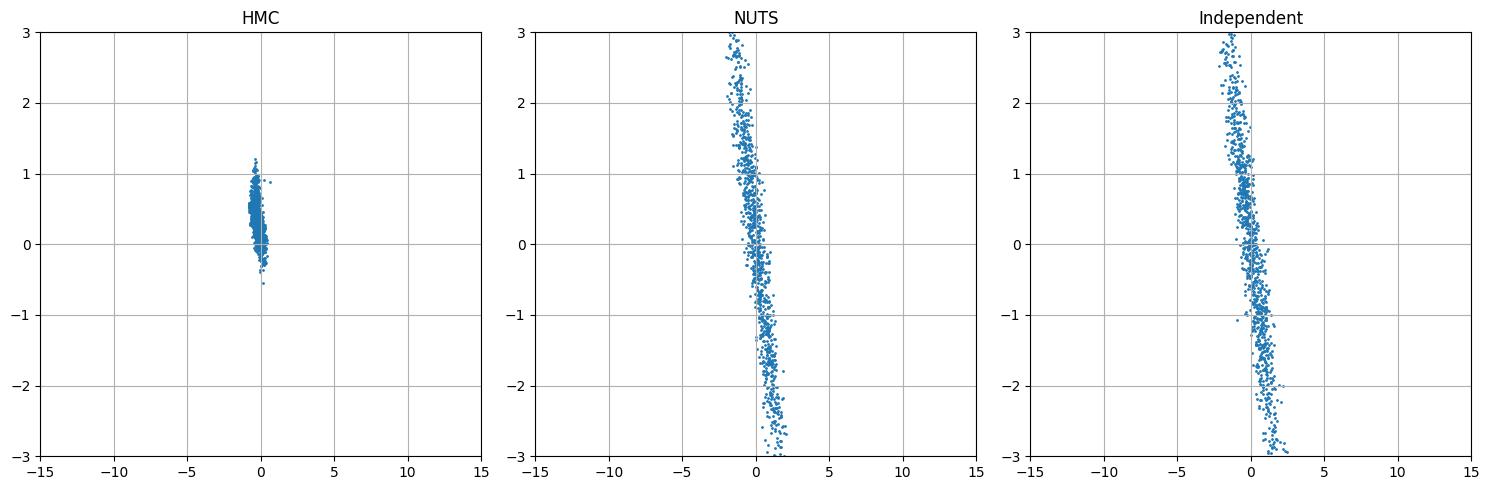

In [3]:
def hmc(log_prob, initial_theta, num_samples, epsilon, L):
    """
    Implements the Hamiltonian Monte Carlo (HMC) algorithm for sampling from a target distribution.

    HMC uses Hamiltonian dynamics to propose new samples, enabling efficient exploration of 
    high-dimensional spaces.

    Parameters:
        log_prob_func (function): Function to compute the log-probability of the target distribution.
        grad_func (function): Function to compute the gradient of the log-probability.
        theta0 (numpy.ndarray): Initial position in parameter space.
        num_samples (int): Number of samples to draw from the target distribution.
        step_size (float): Step size for leapfrog integration.
        num_steps (int): Number of leapfrog steps per iteration.

    Returns:
        samples (numpy.ndarray): Array of samples drawn from the target distribution.
        log_probs (numpy.ndarray): Log-probability values corresponding to the samples.
    """
    D = len(initial_theta)
    samples = np.zeros((num_samples, D))
    theta = initial_theta
    logp, grad = log_prob(theta)

    for i in range(num_samples):
        r0 = np.random.normal(0, 1, D)
        theta0 = theta
        logp0, grad0 = logp, grad

        r = r0 + 0.5 * epsilon * grad0
        for _ in range(L - 1):
            theta = theta + epsilon * r
            logp, grad = log_prob(theta)
            r = r + epsilon * grad

        theta = theta + epsilon * r
        logp, grad = log_prob(theta)
        r = r + 0.5 * epsilon * grad

        r = -r

        current_U = -logp0
        current_K = np.sum(r0**2) / 2.0
        proposed_U = -logp
        proposed_K = np.sum(r**2) / 2.0

        if np.log(np.random.uniform()) < (current_U - proposed_U + current_K - proposed_K):
            samples[i] = theta
        else:
            samples[i] = theta0

    return samples

# Generate samples using each algorithm
num_samples = 1000
burn_in = 1000
total_samples = 1000000 
initial_theta = np.random.normal(0, 1, D)

# HMC parameters
epsilon = 0.01
L = 10

# NUTS sampling
nuts_samples, _, _ = efficient_nuts(log_prob, num_samples, burn_in, initial_theta, delta=0.5)

# HMC sampling
hmc_samples = hmc(log_prob, initial_theta, num_samples, epsilon, L)

# Independent samples from the target distribution
independent_samples = multivariate_normal.rvs(mean=np.zeros(D), cov=Sigma, size=num_samples)

# Generate the plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# HMC
axes[0].scatter(hmc_samples[:, 0], hmc_samples[:, 1], s=1)
axes[0].set_title('HMC')
axes[0].set_xlim([-15, 15])
axes[0].set_ylim([-3, 3])
axes[0].grid(True)

# NUTS
axes[1].scatter(nuts_samples[:, 0], nuts_samples[:, 1], s=1)
axes[1].set_title('NUTS')
axes[1].set_xlim([-15, 15])
axes[1].set_ylim([-3, 3])
axes[1].grid(True)

# Independent samples
axes[2].scatter(independent_samples[:, 0], independent_samples[:, 1], s=1)
axes[2].set_title('Independent')
axes[2].set_xlim([-15, 15])
axes[2].set_ylim([-3, 3])
axes[2].grid(True)

plt.tight_layout()
plt.show()